In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packag

In [2]:
e = exp.load('iter_exps21', experiment_location='experiments', datadir='Mdata')
e.trials_df

,trial_idx,model_name,expt,"(0, 0, reg_vals, d2t)","(0, 0, reg_vals, center)","(0, 1, reg_vals, center)","(0, 2, reg_vals, d2xt)","(0, 2, reg_vals, center)","(0, 3, reg_vals, center)","(0, 4, reg_vals, d2xt)","(0, 4, reg_vals, center)","(1, 0, reg_vals, glocal)",num_iter,num_lags,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04+expt06+expt09+expt11,0.0001,0.0,0.0001,0.0001,0.0,0.0001,0.0001,0.0,0.0,2,14,TconvScaffoldIter0,<experiment.Trial object at 0x7f17ad5b3a50>,0.113543


In [15]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

array([  0,  35,  63,  86, 111])

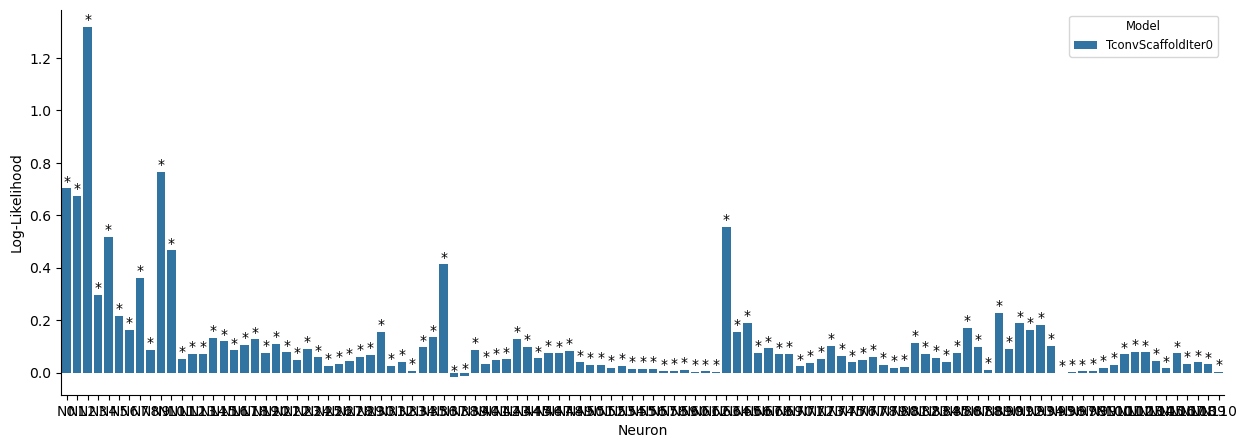

In [35]:
e.plot_LLs()

(148, 111)


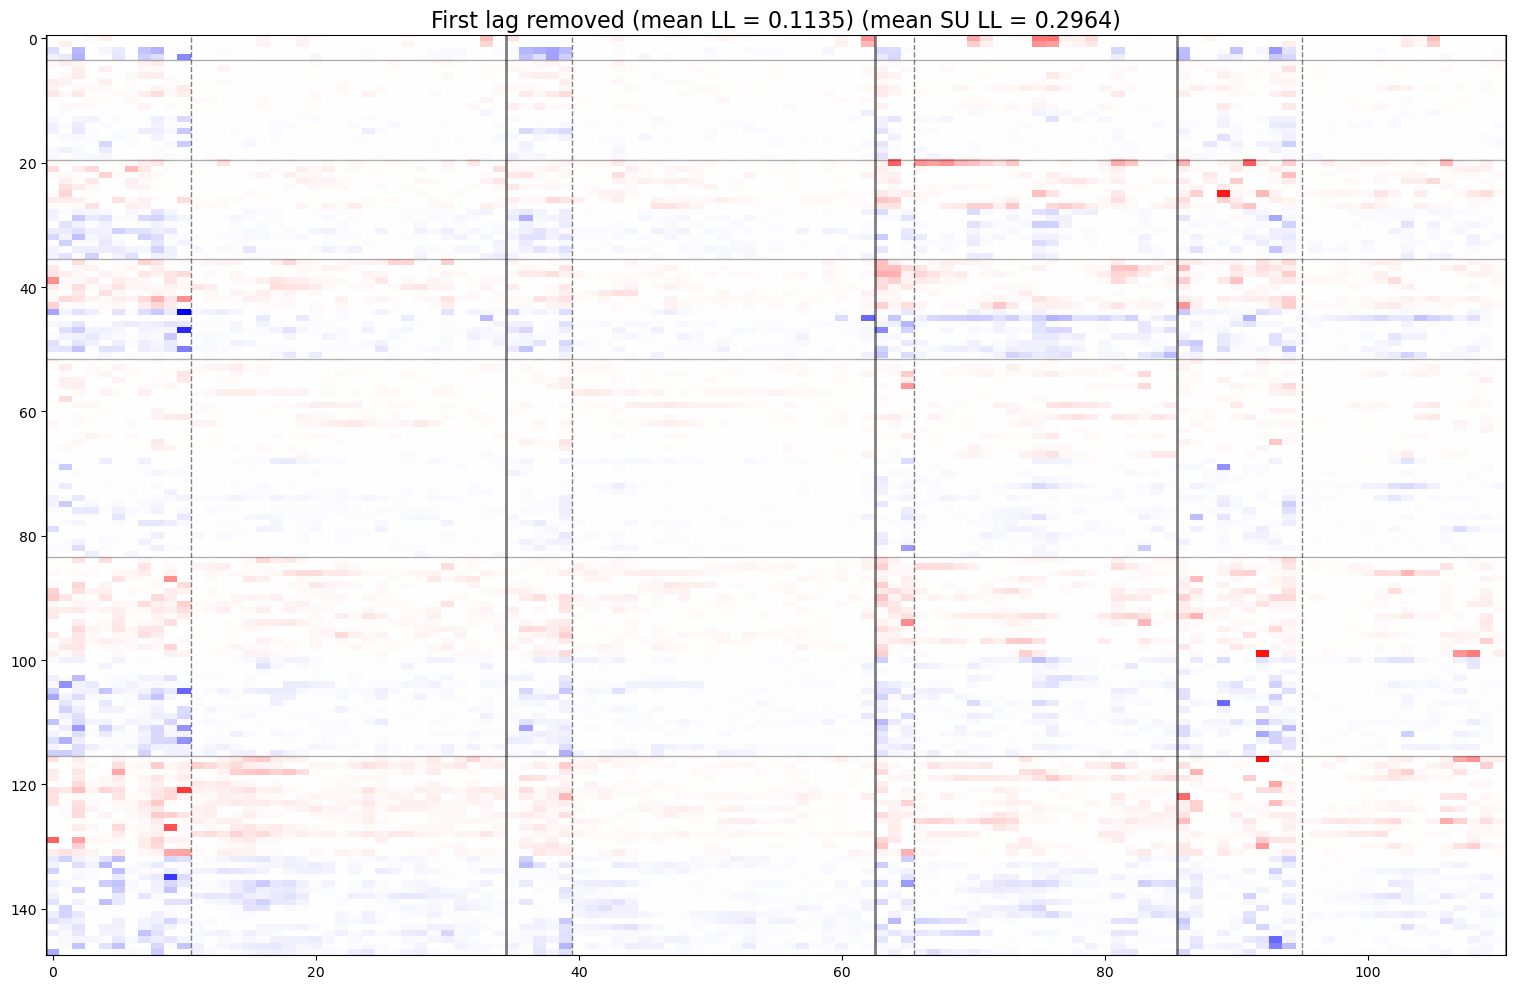

In [34]:
names = ['First lag removed', 'No lag removed']
fig = plt.figure(figsize=(30,10))
for j, trial in enumerate(e.trials[:2]):
    ax = plt.subplot(1,2,j+1)
    readout_weights = np.sum(trial.model.networks[-1].layers[-1].weights[:,:,:], axis=1)
    print(readout_weights.shape)
    # make inhibitory weights negative (every 12 weights need to be flipped)
    readout_weights[2:4,:] = -readout_weights[2:4,:]
    for i in range(12,60,16):
        readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]
    for i in range(68,164,32):
        readout_weights[i:i+16,:] = -readout_weights[i:i+16,:]

    # get the mean LLs for just the SUs in k
    mean_SU_LLs = np.mean(trial.LLs[dataset.SUs])

    # get the mean LLs for k
    mean_LLs = np.mean(trial.LLs)

    plot.imagesc(readout_weights, ax=ax, cmap='bwr', colrow=False, origin='upper')
    ax.set_title(names[j] + ' (mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
    #ax.axis('off')

    # put a vertical line between each experiment
    for expt_boundary in expt_boundaries:
        plt.axvline(expt_boundary-0.5, color='k', linewidth=2, alpha=0.5)

    # put a vertical line between the SUs and the MUs
    # get the indices of the SUs where the experiment boundaries are
    SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

    for SU_boundary in SU_boundaries:
        ax.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
    # plot the last SU boundary
    plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

    layer_boundaries = [0, 4, 20, 36, 52, 84, 116, 148]

    # put a horizontal line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        ax.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

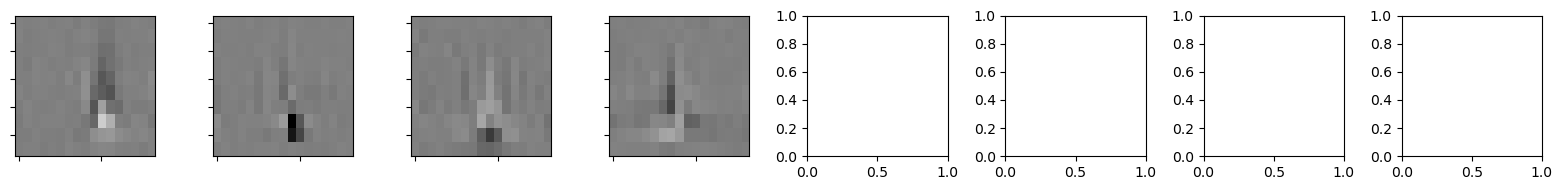

In [17]:
e.trials[0].model.NDN.plot_filters()